# Vision

A significant part of this project relies on computer vision. We made extensive use of the *OpenCV* library to implement the image-processing pipeline that enables the robot to interpret its environment. All vision-related functionalities are organized within a dedicated `VisionSystem` class, implemented in the file *vision_system.py*.

The camera was placed above the setup at a slight angle. As a first step, we calibrated the image by detecting ArUco markers positioned around the environment. These markers allowed us to isolate and crop the relevant rectangular area. We then applied a perspective transform to obtain a top-down, orthonormal view of the scene, which became the reference frame for all subsequent processing. ArUco markers were also used to detect both the robot and the goal position.

To detect obstacles, we initially considered using black objects combined with classical edge detection. However, the presence of other dark elements in the scene such as the ArUco markers and parts of the Thymio robot made this approach unreliable. We therefore switched to using blue obstacles and applied color filtering to extract blue regions from the image. This method turned out to be highly effective and was ultimately adopted in our final pipeline.

METTRE PHOTO DU SETUP

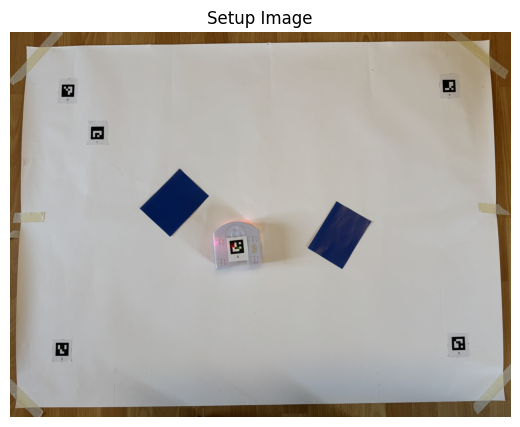

In [15]:
import cv2
import numpy as np
from cv2 import aruco
import matplotlib.pyplot as plt

image = cv2.imread("true_setup.jpg")

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Setup Image")
plt.show()

At the beginning of the project, we planned to use the provided Aukey webcam. However, once we started coding and sharing our programs, we quickly ran into practical issues since we only had a single webcam. As we all work on Mac, a much more efficient solution was to use our iPhones as cameras instead. Thanks to the Apple ecosystem, each of us could easily use our iPhone camera as an external webcam for our MacBooks. This gave us higher image quality and allowed everyone to run and test the vision code independently, without relying on the one shared webcam.

We began by implementing the `VisionSystem` constructor, which initializes all required variables. It opens the camera stream using OpenCV’s `VideoCapture` and loads the ArUco dictionary.

In [16]:
class VisionSystem:

    def __init__(self, camera_id=0, aruco_dict_type=aruco.DICT_4X4_50):
        self.cap = cv2.VideoCapture(camera_id)
        self.aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
        self.aruco_params = aruco.DetectorParameters()

        # Initialize variables
        self.detected_markers = {}
        self.corners = None  # [(x1, y1), ...]
        self.transform_matrix = None
        self.mm2px = None
        self.map_size = (900, 600)
        self.goal_position = None  # (x, y)

The core of the setup is the `calibrate` function, which reads frames from the camera and detects all relevant ArUco markers. To differentiate their roles, we pass two parameters: `corner_ids` for the four map corners and `goal_id` for the goal marker.
Once all four corner markers are detected, we order them, draw their positions in green on the displayed image, and connect them with green lines to visualize the rectangular map region that will be extracted. We also highlight the goal marker with a circle and label it “GOAL”.


METTRE SCREEN DES LIGNES VERTES

When the user is satisfied with the setup and marker detection, pressing the “c” key completes the calibration. This triggers the perspective transform and computes the millimeter-to-pixel scaling factor used throughout the rest of the project.

METTRE SCREEN DE L’AFFICHAGE APRES C

### Converting Real-World Distances (mm) to Pixels

During calibration, the physical height of the map is known:

$$H_{\text{real}} \text{ (in mm)} $$

and the corresponding height in the transformed top-down image is fixed:

$$H_{\text{px}} \text{ (in pixels)} $$

The conversion factor from millimeters to pixels is therefore:
$$ \text{mm2px} = \frac{H_{\text{px}}}{H_{\text{real}}} $$

This scalar tells us how many pixels correspond to one millimeter in the real world.  
It allows converting any real-world measurement $d_{\text{mm}}$ into pixel units:
$$ d_{\text{px}} = d_{\text{mm}} \cdot \text{mm2px} $$


### Robot pose detection

We use the function `detect_raw_robot_pose` to detect the robot pose, and get its orientation. To do this, we use trigonometry. Here is the thought process behind the robot orientation estimation from the aruco marker :

In [3]:
def detect_robot_raw_pose(self, frame):
    """
    Returns:
        np.array: [x, y, theta] in map coordinates, or None if not detected
    """

    marker_centers = self._detect_marker_centers(frame, target_ids={4})

    if 4 not in marker_centers:
        print("Robot marker not detected!")
        return None

    robot_data = self.detected_markers[4]

    corners = robot_data['corners'] # Orientation, corners are: TL, TR, BR, BL

    tl = corners[0]
    tr = corners[1]

    top_center = (tl + tr) / 2
    center = robot_data['center']
    x, y = center

    dx = top_center[0] - center[0]
    dy = top_center[1] - center[1]

    theta = np.arctan2(dy, dx) # Compute angle in radians

    return np.array([x, y, theta])

To compute the robot’s orientation, we use the top edge of the ArUco marker as a reference direction.

Given the marker corners TL and TR, and the marker center c, we define:

$$
m = \frac{TL + TR}{2}
$$

$$
v = m - c
$$

Component-wise:

$$
v_x = m_x - c_x, \qquad v_y = m_y - c_y
$$

The robot’s orientation angle is then obtained using:

$$
\theta = \operatorname{atan2}(v_y, v_x)
$$

This angle corresponds to the direction from the center of the marker toward the top edge, expressed in radians.


### Obstacle detection and Image processing

**Pipeline for obstacle detection and Image processing :**
1. Obtain the cropped and Perspective transformed Image from the calibration.

2. Use that Image, and convert it to HSV.

3. Generate a binary mask that filters the non-blue colors, using predefined thresholds in the HSV Image.

4. Perform morphological operations on the mask to clean and improve the shapes :
- We use `MORPH_OPEN` (erosion followed by dilation), to remove small white noise.
- and `MORPH_CLOSE` (dilation followed by erosion), to fill small black holes and to connect nearby white regions.

5. Apply a gaussian blur as a pre-processing step, before performing Canny edge detection.

6. Dilate the edges to make theam more visible.

7. Scale the edges and detect contours of polygonal obstacles.

8. Draw the polygonal shapes, as well as their vertices (red points) on the displayed image.

To detect obstacles, we first capture frames from the camera and apply a color filter using OpenCV’s `inRange` function (with a lower and upper threshold for blue) on the HSV representation of the image. This produces a mask, isolating only the blue pixels corresponding to our obstacles.

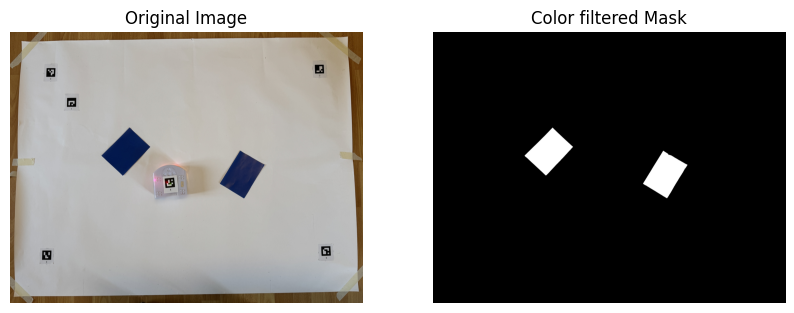

In [ ]:
from code_for_report import filter_color

mask = filter_color(image)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Color filtered Mask")
plt.imshow(mask, cmap="gray")
plt.axis('off')

plt.show()

Next, we apply a 3×3 Gaussian blur on the mask to reduce noise, followed by Canny edge detection to extract the contours of the polygonal obstacles.

METTRE SCREEN DU CANNY

<Figure size 1000x500 with 0 Axes>

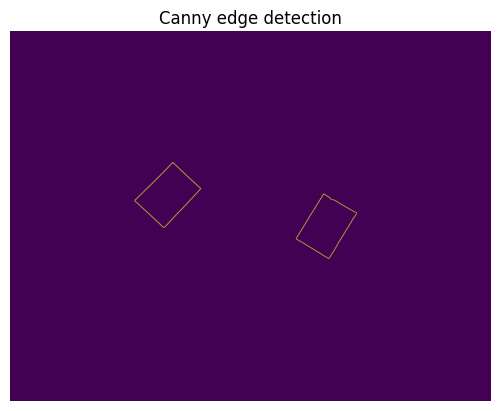

In [5]:
from code_for_report import process_image

edges = process_image(mask)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.figure()
plt.imshow(edges, cmap='viridis')
plt.axis('off')
plt.title("Canny edge detection")
plt.show()

With this edge image, we scale each obstacle’s contour using our custom `scale_contour` function, and then use the very powerful OpenCV functions `findContours `and `approxPolyDP` in our `detect_contours` function to recover the vertices of the scaled shapes. To avoid false positives, we restrict the obstacles to polygons with exactly four vertices.

Finally, we draw the scaled polygons in red, along with red circles indicating each detected vertex, on the output frame.


METTRE SCREEN DES SCALED POLYGONS

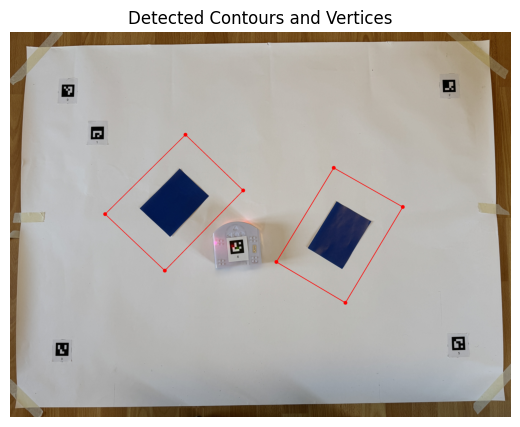

In [6]:
from code_for_report import detect_contours, draw_contours

scaled_contours, all_vertices = detect_contours(edges)
output_image = draw_contours(image, scaled_contours, all_vertices)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detected Contours and Vertices")
plt.show()

# Kalman Filter

### Why do we need a Kalman filter
In this project, we need an accurate estimate of the robot’s pose throughout its motion. Using only the top camera would give us a rough estimate of the Thymio’s position, but it is often noisy and prone to errors, which can lead to unstable or undesired behavior. To address this, we integrate a Kalman filter that fuses information from both the camera and the robot’s odometry. This combination provides a smoothed, robust, and reliable estimate of the robot’s position.

Beyond improving accuracy, the Kalman filter also allows us to predict future states using a motion model. This becomes essential when visual tracking is temporarily lost for example, if the camera view is obstructed or if the robot is moved unexpectedly (“kidnapped”). In such cases, the filter maintains a belief about the robot’s pose, with an uncertainty that naturally increases over time.

### We implmented an Extended Kalman filter - Why ?
We chose to implement an Extended Kalman Filter (EKF) because the Thymio’s motion model is nonlinear. While a standard Kalman filter applies only to linear systems, the EKF linearizes the nonlinear dynamics around the current state estimate, making it suitable for mobile robots like ours. This is consistent with the EKF formulation introduced in the MICRO-452 course.

Given the scope of the project, we implemented a simple version of the EKF. We initially looked at general explanations such as the Kalman Filter Wikipedia page, but the theory was too broad for our needs. We then asked ChatGPT for a concise overview and a pseudocode outline, which helped us structure our implementation.


In our EKF, the state vector is very basic and consists of only three variables:

$$
\mathbf{x} = 
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}
$$

### Main EKF Variables

- **State vector:**  $\mathbf{x} = [x, y, \theta]^\top$

- **Motion model:**  $\mathbf{g}(\mathbf{x})$

- **Measurement model:**  $\mathbf{h}(\mathbf{x})$

- **Covariance matrix:**  $\mathbf{P}$

- **Jacobians:**  $\mathbf{G} = \frac{\partial \mathbf{g}}{\partial \mathbf{x}}$, $\mathbf{H} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}}$

Now, let's get into more details for these variables :

### Measurement Model

- $\mathbf{z}$ : measure given by the external sensor (camera) with noise, error and fluctuations

$$
\mathbf{z} = 
\begin{bmatrix}
x_{\text{cam}} \\
y_{\text{cam}} \\
\theta_{\text{cam}}
\end{bmatrix}
$$

- $\mathbf{h}(\mathbf{x})$ : Measurement model - Since the sensor observes the pose directly, it is:

$$
\mathbf{h}(\mathbf{x}) =
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}
$$

- The **innovation** $\mathbf{i}_k$ is:

$$
\mathbf{i}_k = \mathbf{z}_k - \mathbf{h}(\hat{\mathbf{x}}_{k|k-1})
$$

- $\mathbf{H}$ : The Jacobian of the measurement model is simply:

$$
\mathbf{H} =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
= \mathbf{I}_3
$$


### Motion Model

We define differential-drive kinematics with wheel speeds $\mathbf{v_L}$ and $\mathbf{v_R}$, wheel separation $\mathbf{L}$, and timestep $\Delta \mathbf{t}$.

- Linear and angular velocities:

$$
\begin{cases}
v = \frac{v_L + v_R}{2}, \\
\omega = \frac{v_L - v_R}{L}
\end{cases}
$$

- $\mathbf{g}(\mathbf{x})$ : The predicted state according to the motion model is:

$$
\mathbf{g}(\mathbf{x}) =
\begin{bmatrix}
x + v\Delta t \cos\theta \\
y + v\Delta t \sin\theta \\
\theta + \omega \Delta t
\end{bmatrix}
$$

- $\mathbf{G}$ : the Jacobian of the motion model is :

$$
\mathbf{G} =
\frac{\partial \mathbf{g}}{\partial \mathbf{x}} =
\begin{bmatrix}
1 & 0 & -v \Delta t \sin\theta \\
0 & 1 & \;\;v \Delta t \cos\theta \\
0 & 0 & 1
\end{bmatrix}
$$

### Covariance Matrix (**P**) :

It represents the uncertainty in the estimated state and its correlations.

$$
\mathbf{P} =
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} & \sigma_{x\theta} \\
\sigma_{yx} & \sigma_y^2 & \sigma_{y\theta} \\
\sigma_{\theta x} & \sigma_{\theta y} & \sigma_\theta^2
\end{bmatrix}
$$

## EKF Algorithm
The formulas of the predict and update functions of the EKF algorithm were deducted from Wikipedia [Link Text](https:// en.wikipedia.org/wiki/Extended_Kalman_filter) :

1. **Predict**

- State prediction: 
$\hat{\mathbf{x}}_{k|k-1} = \mathbf{g}(\hat{\mathbf{x}}_{k-1})$

- Covariance prediction: 
$\mathbf{P}_{k|k-1} = \mathbf{G}_k \, \mathbf{P}_{k-1} \, \mathbf{G}_k^\top + \mathbf{Q}$


2. **Update**

- Innovation: $\mathbf{i}_k = \mathbf{z}_k - \mathbf{h}(\hat{\mathbf{x}}_{k|k-1})$

- Innovation covariance: $\mathbf{S}_k = \mathbf{H}\mathbf{P}_{k|k-1}\mathbf{H}^\top + \mathbf{R}$

- Kalman gain: $\mathbf{K}_k = \mathbf{P}_{k|k-1}\mathbf{H}^\top \mathbf{S}_k^{-1}$

- Updated state: $\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \mathbf{i}_k$

- Updated covariance: $\mathbf{P}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H})\, \mathbf{P}_{k|k-1}$


## Estimation of the Noise Matrices $\mathrm{R}$ and $\mathrm{Q}$

In an Extended Kalman Filter (EKF), the noise matrices $\mathrm{Q}$ and $\mathrm{R}$ define how uncertainty is modeled in the system. The matrix $\mathrm{R}$ characterizes the measurement noise of the camera (Aruco detection), while $\mathrm{Q}$ models the process noise, i.e., the inaccuracy of the robot’s motion model. Their correct estimation is essential for a stable and reliable EKF.

### Measurement Noise $\mathrm{R}$

The measurement equation of the EKF is:
$$
z_k = h(x_k) + v_k, \qquad v_k \sim \mathcal{N}(0, R)
$$

Since our camera directly provides an estimate of $(x, y, \theta)$, the matrix $\mathrm{R}$ represents the covariance of the noise in these three measured quantities.
To estimate $\mathrm{R}$ experimentally, we recorded 20 seconds of ArUco detections while the robot was completely immobile under the overhead camera. During this experiment, any variation in the detected poses is caused solely by sensor noise. We logged data at 30 Hz into a CSV file containing:

In [ ]:
timestamp, x_cam, y_cam, theta_cam, vL, vR

Using these samples, we computed the variance and covariance of $x, y,$ and $\theta$, which directly gives the matrix $\mathrm{R}$. Angle measurements were unwrapped before computing the covariance.

$$
R = \mathrm{Cov}\!\left(\begin{bmatrix} x_i - \bar{x} \\[4pt] y_i - \bar{y} \\[4pt] \theta_i - \bar{\theta} \end{bmatrix}\right)
$$

The result is a $3 \times 3$ matrix. It is computed with a python script `log_data.py`, it is stored as `R.npy` and used directly by the EKF.


### Process Noise $\mathrm{Q}$

The process model of our differential-drive robot predicts the next state using:
$$
x_{k+1} = g(x_k, u_k) + w_k, \qquad w_k \sim \mathcal{N}(0, Q)
$$

The matrix $\mathrm{Q}$ therefore quantifies how much the real motion deviates from this idealized kinematic model.
To estimate $\mathrm{Q}$, we conducted a second 20 second experiment where the robot moved slowly with fixed wheel speeds ($v_L = 50, v_R = 40$)​, producing a slightly curved trajectory. We then logged data at 30 Hz into another CSV file with the same contents as for $\mathrm{R}$.

### Computation of $\mathrm{Q}$ :
For each interval $[k,k+1]$ :
- 1. We compute the predicted pose using the differential-drive model:
$$
x_{k+1}^{\text{pred}} = g(x_k^{\text{cam}},\, u_k)
$$

- 2. We compare it with the actual next pose from the camera:
$$
e_k = x_{k+1}^{\text{cam}} - x_{k+1}^{\text{pred}}
$$

- 3. We accumulate these residuals and compute their covariance:
$$
Q = \mathrm{Cov}(e_1,\, e_2,\, \ldots,\, e_N)
$$

As for $\mathrm{R}$, we unwrap the angle difference to avoid angle jumps before computing the covariances.

This gives a $3 \times 3$ matrix. It is computed with a python script `log_data.py`, saved as `Q.npy` and used in the EKF prediction step.